# Fine Clustering

Inspired by the Transient analysis, the idea here is to first cluster cells into a large number of small clusters with ~1000 cells each, and then cluster peaks that light up in sets of cell clusters. This would enable a better analysis of transient peaks.

**TODO**: In the future, precompute clusters at different resolutions and store in metadata.tsv

In [4]:
library(SnapATAC)
library(reshape2)
library(viridis)
library(scales)
library(ggplot2)
library(ggrepel)
library(DESeq2)
library(ClusterR)
library(RColorBrewer)
library(patchwork)
library(cowplot)

Loading required package: Matrix

Loading required package: rhdf5

Loading required package: viridisLite


Attaching package: ‘scales’


The following object is masked from ‘package:viridis’:

    viridis_pal


Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:SnapATAC’:

    colMeans, colSums, rowMeans, rowSums


The following objects are masked from ‘package:Matrix’:

    colMeans, colSums, rowMeans, rowSums, which


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated,

In [5]:
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))

In [6]:
DAYS = c()
FILE_PREFIX = "/srv/scratch/surag/scATAC-reprog/snap"

file.list = c()
barcode.file.list = c()

for (i in seq(0, 14, 2)) {
    DAYS = c(DAYS, sprintf("D%d", i))
    file.list = c(file.list, sprintf("%s/D%d.snap", FILE_PREFIX, i))
}
DAYS
file.list

[1] "D0"  "D2"  "D4"  "D6"  "D8"  "D10" "D12" "D14"

[1] "/srv/scratch/surag/scATAC-reprog/snap/D0.snap" 
[2] "/srv/scratch/surag/scATAC-reprog/snap/D2.snap" 
[3] "/srv/scratch/surag/scATAC-reprog/snap/D4.snap" 
[4] "/srv/scratch/surag/scATAC-reprog/snap/D6.snap" 
[5] "/srv/scratch/surag/scATAC-reprog/snap/D8.snap" 
[6] "/srv/scratch/surag/scATAC-reprog/snap/D10.snap"
[7] "/srv/scratch/surag/scATAC-reprog/snap/D12.snap"
[8] "/srv/scratch/surag/scATAC-reprog/snap/D14.snap"

In [7]:
x.sp.ls = lapply(seq(file.list), function(i) {
    x.sp = createSnap(file = file.list[i],                      
                     sample = DAYS[i])
    x.sp
})

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...

Epoch: reading the barcode session ...



In [8]:
# Metadata file from previous run
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../20200206_pmat_snapATAC/sessions/20200220_n74838/metadata.tsv", header = T)
metaData$barcode = lapply(strsplit(rownames(metaData), '_'), "[[", 2)
metaData = metaData[order(rownames(metaData)), ]
head(metaData, 2)

sample umap.1   umap.2    cluster barcode         
D0_AAACAACGACGATTAC D0     6.545686 -7.701751 2       AAACAACGACGATTAC
D0_AAACAACGACTCACGG D0     5.180663 -7.633298 2       AAACAACGACTCACGG

In [9]:
# Filter cells 
x.sp.list = lapply(seq(x.sp.ls), function(i){
  x.sp = x.sp.ls[[i]];
  x.sp  = x.sp[x.sp@barcode %in% metaData[as.character(metaData$sample)==DAYS[i], "barcode"],];
})
names(x.sp.list) = DAYS;

In [ ]:
x.sp.list = lapply(seq(x.sp.list), function(i) {
    x.sp = addPmatToSnap(x.sp.list[[i]], num.cores=5)
    x.sp
})

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...

Epoch: reading cell-peak count matrix session ...



In [ ]:
# merge timepoints
x.sp = Reduce(snapRbind, x.sp.list);

In [ ]:
# order by sample_barcode
x.sp = x.sp[order(paste(x.sp@sample, x.sp@barcode, sep='_')), ]

In [ ]:
# Note that the peaks matrix is not binarized

In [ ]:
x.sp@cluster = factor(metaData$cluster)
slot(x.sp, "umap") = as.matrix(metaData[, c("umap.1", "umap.2")])

In [ ]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, x.sp@sample)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=x.sp.sample)) +
scale_color_brewer(breaks=DAYS, palette = "Set1") +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5)) + 
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 

## Finer Clustering

In [ ]:
library(RANN)
library(leiden)

In [ ]:
feats = read.table("../20200206_pmat_snapATAC/sessions/20200220_n74838/features.tsv", header = T)
feats = feats[order(rownames(feats)),]
feats = feats[, 5:ncol(feats)]
head(feats,3)

In [ ]:
K = 15

nn.ranked <- nn2(
        data = feats,
        k = K,
        searchtype = 'standard',
        eps = 0)$nn.idx;

j <- as.numeric(x = t(x = nn.ranked))
i <- ((1:length(x = j)) - 1) %/% K + 1
edgeList = data.frame(i, j, 1);
kmat = Matrix(0, nrow(feats), nrow(feats), sparse=TRUE);
kmat = sparseMatrix(i = edgeList[,1], j = edgeList[,2], x = edgeList[,3]);
nn_graph = SnapATAC:::newKgraph(mat=kmat, k=K, snn=FALSE, snn.prune=1/15);

In [ ]:
clusters = leiden(SnapATAC:::getGraph(nn_graph), resolution=2)

In [ ]:
table(clusters)

In [ ]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, clst=as.factor(clusters))
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=clst)) +
# scale_color_brewer( palette = "Set1") +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5)) +
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 

## Make pseudo-bulk matrix

In [ ]:
agg_matrix = sparseMatrix(i=clusters,
                         j=seq(1,nrow(x.sp)),
                         x=1L,
                         dims=c(length(table(clusters)), nrow(x.sp)))

In [ ]:
cts = as.matrix(agg_matrix %*% x.sp@pmat)
colnames(cts) = as.character(x.sp@peak)
rownames(cts) = paste("cluster", seq(1,nrow(cts)), sep="_")
cts = t(cts)
head(cts)

In [ ]:
cts = cts[rowSums(cts)>50, ]
dim(cts)

In [ ]:
norm_cts = t(t(cts)/estimateSizeFactorsForMatrix(cts))

In [ ]:
log_norm_cts = log2(1+norm_cts)

In [69]:
cts_to_cluster = log_norm_cts 
# cts_to_cluster = t(scale(t(log_norm_cts)))

In [70]:
# ADD RAND SEED - not required

km_mb = MiniBatchKmeans(cts_to_cluster, 
                        batch_size = 1000,
                        clusters=15,
                        num_init = 10, 
                        verbose = FALSE)

In [71]:
# reorder based on hierarchical clustering
# pr_mb = predict_MBatchKMeans(cts_to_cluster, km_mb$centroids)

# distance    = dist(t(scale(t(km_mb$centroids))))
# cluster     = hclust(distance, method="ward")
# dendrogram  = as.dendrogram(cluster)
# rowInd = rev(order.dendrogram(dendrogram))
# pr_mb = order(rowInd)[pr_mb]

In [72]:
# no hierarchical clustering, follow order of km_mb$centroids
pr_mb = predict_MBatchKMeans(cts_to_cluster, km_mb$centroids)

In [73]:
table(pr_mb)

pr_mb
    1     2     3     4     5     6     7     8     9    10    11    12    13 
40224 33546 15132 34220 38434 13433 30422 25607 24885 31455 35060 39825 36179 
   14    15 
38098 20957 

In [77]:
order(rowVars(km_mb$centroids))

[1]  9  2 12  3  1 11  4 14  5 13  8 10  7  6 15

In [78]:
cts_clustered = cts_to_cluster[order(pr_mb),]
head(cts_clustered, 2)

cluster_1 cluster_2 cluster_3 cluster_4 cluster_5 cluster_6
chr1:184385-184585 3.135676  2.064380  3.991536  2.343562  3.527492  2.238672 
chr1:586102-586306 2.966292  3.779277  2.577441  3.797624  3.527492  3.744026 
                   cluster_7 cluster_8 cluster_9 cluster_10 ⋯ cluster_26
chr1:184385-184585 2.849367  2.939088  2.407725  3.725791   ⋯ 2.854732  
chr1:586102-586306 3.153743  3.459943  3.861390  3.451177   ⋯ 2.854732  
                   cluster_27 cluster_28 cluster_29 cluster_30 cluster_31
chr1:184385-184585 2.196972   2.627777   3.140429   2.625733   2.802270  
chr1:586102-586306 3.030392   1.844131   1.850381   2.935401   2.317183  
                   cluster_32 cluster_33 cluster_34 cluster_35
chr1:184385-184585 3.466559   3.741435   3.529296   3.821602  
chr1:586102-586306 3.176894   1.796989   3.771353   3.174622

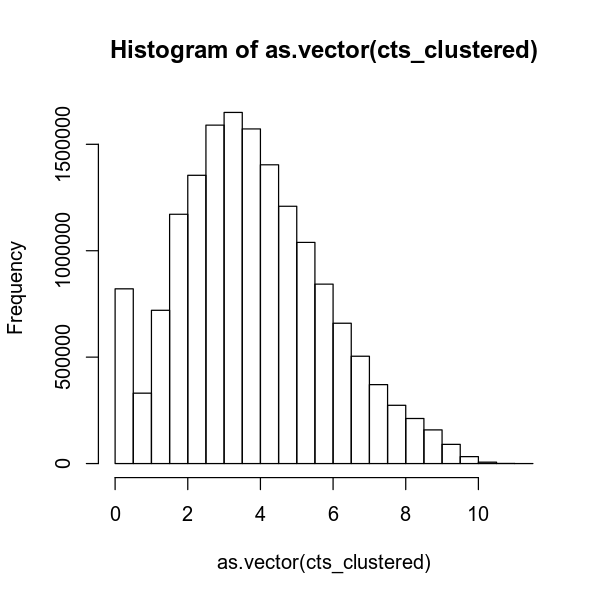

In [79]:
options(repr.plot.width = 5, repr.plot.height = 5)
hist(as.vector(cts_clustered))

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 10)

idxs = seq(1, nrow(cts_clustered), 10) # if subsample
ggplot(data = melt(cts_clustered[idxs, ]), 
       mapping = aes(x = Var2,
                     y = Var1,
                     fill = value)) +
geom_tile()  + ylab(NULL) + xlab("Condition") +  
geom_raster(aes(fill=value)) +
scale_fill_viridis(limits=c(0, 8), oob=squish, option = "A") +
# scale_fill_viridis(option="A") + 
# scale_fill_gradient2(low="red", mid="black", high="blue") +
facet_grid(sort(pr_mb)[idxs] ~ ., switch = "y", scales = "free_y", space = "free_y")+
# theme_classic() +
theme(axis.text.x=element_text(angle=90,hjust=1),
      axis.text.y=element_blank(),
      axis.ticks.y=element_blank())
#       panel.spacing.y = unit(0.03, "cm"),
#       strip.text.y = element_text(size = 3))  
#       strip.background = element_rect(size = 0.1))

# ggsave(sprintf("figs/%s_heatmap_idr_n%d.jpeg", format(Sys.Date(), format='%Y%m%d'), length(table(pr_mb))),
#        dpi=1000)

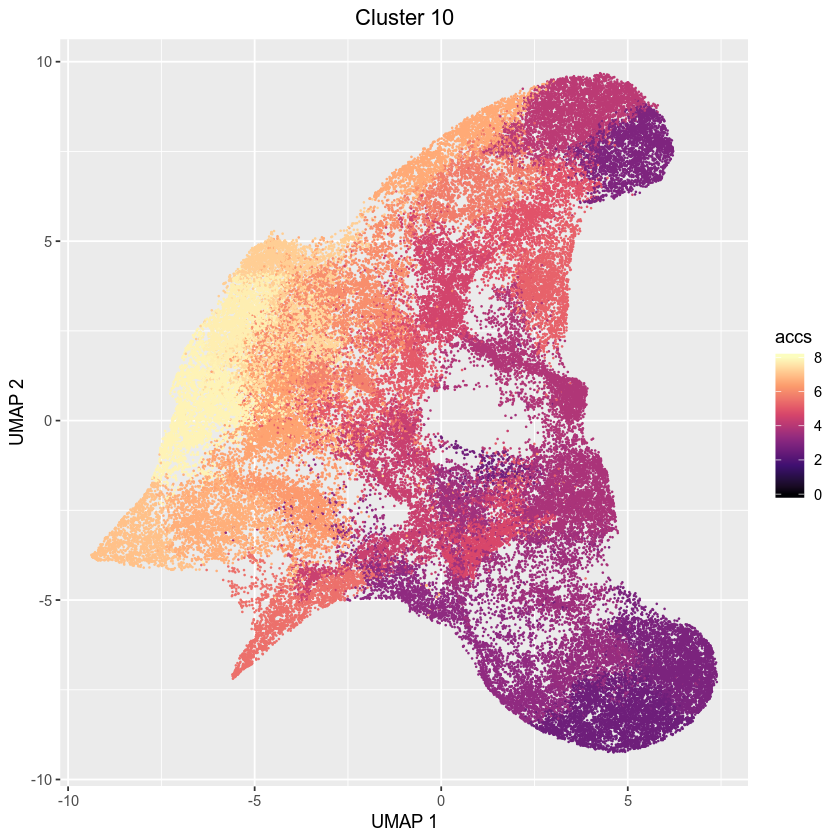

In [288]:
options(repr.plot.width = 7, repr.plot.height = 7)
selected_cluster_id = 10

# visualize a centroid
# df = data.frame(x.sp@umap, accs=km_mb$centroids[selected_cluster_id, ][clusters])

# or a specific peak
df = data.frame(x.sp@umap, accs=log_norm_cts["chr22:35431834-35432287", ][clusters])

# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.1, alpha=1, aes(x=umap.1 , y=umap.2, col=accs)) +
ggtitle(sprintf("Cluster %d", selected_cluster_id)) + 
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(limits=c(0, 8), oob=squish, option = "A") +
theme(plot.title = element_text(hjust = 0.5))

In [80]:
plots = list()
for (i in seq(1,15)) {
    df = data.frame(x.sp@umap, centroid_accs=km_mb$centroids[i, ][clusters])
    # shuffle so days don't overlap
    df = df[sample(dim(df)[1], 20000), ]
    
    plots[[i]] <- ggplot(df) +
    # ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
    geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=centroid_accs)) +
    ggtitle(sprintf("Cluster %d", i)) + 
    xlab("UMAP 1") + ylab("UMAP 2") +
    scale_color_viridis_c(limits=c(0, 8), oob=squish, option = "A") +
    theme(plot.title = element_text(hjust = 0.5),
         legend.position = "none",
         axis.ticks = element_blank(),
         axis.text =element_blank())
}

In [81]:
# get legend
df = data.frame(x.sp@umap, znorm_gene_scores=km_mb$centroids[1, ][clusters])
# shuffle so days don't overlap
df = df[sample(dim(df)[1], 20000), ]

cur_plot <- ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=znorm_gene_scores)) +
ggtitle(sprintf("Cluster %d", i)) + 
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(limits=c(0, 8), oob=squish, option = "A") +
theme(plot.title = element_text(hjust = 0.5),
     axis.ticks = element_blank(),
     axis.text =element_blank())

legend_only = cowplot::get_legend(cur_plot)

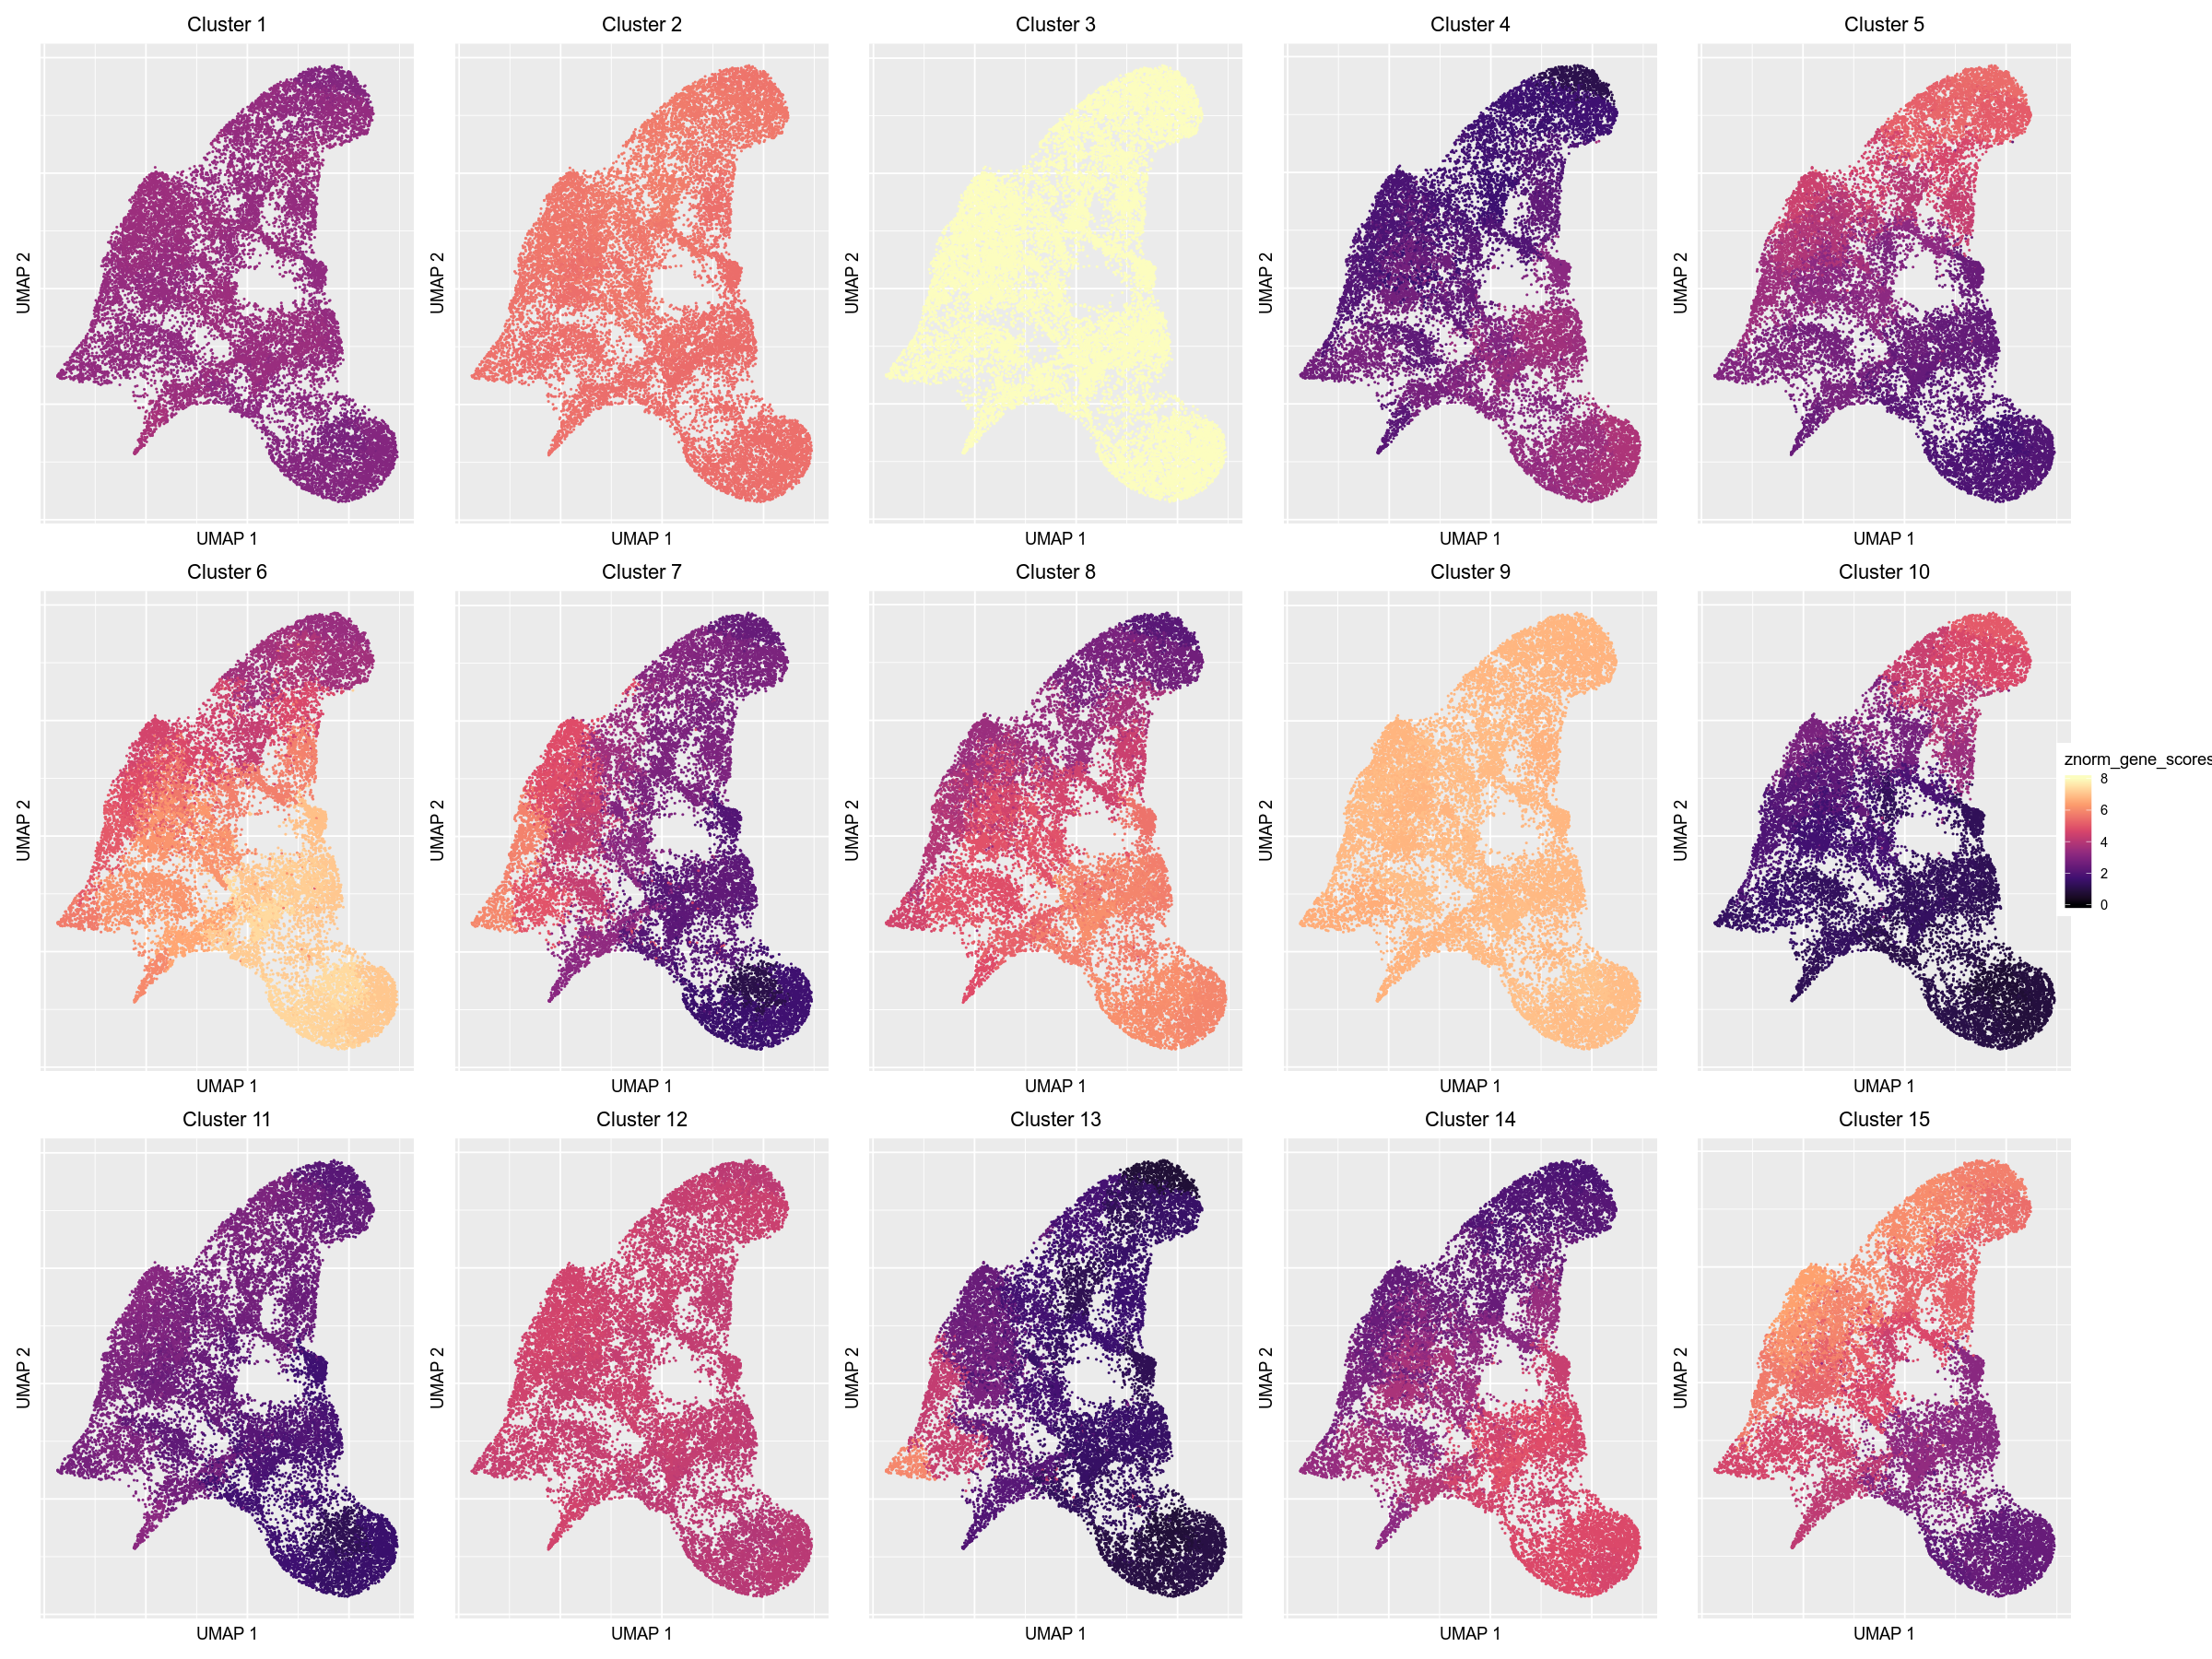

In [82]:
options(repr.plot.width = 20, repr.plot.height = 15)
wrap_plots(wrap_plots(plots, ncol = 5), legend_only, widths=c(0.95,0.05))

## Writing BED files for some clusters

In [160]:
CLUSTER_IDX = 1
NORM = 'gridmap_naive'
BED_PATH = sprintf("beds/%s_%s_n%d/idx%d.bed", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)), CLUSTER_IDX)
# rownames(vsd_assay_to_cluster_normalized)[(which(pr_mb==CLUSTER_IDX))]
BED_PATH

[1] "beds/20200307_gridmap_naive_n15/idx1.bed"

In [165]:
for (i in seq(1,length(table(pr_mb)))){
BED_PATH = sprintf("beds/%s_%s_n%d/idx%d.bed", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)), i)
fileConn = file(BED_PATH)
writeLines(sub('-', '\t', sub(':', '\t', rownames(cts_to_cluster)))[(which(pr_mb==i))], fileConn)
close(fileConn)}

In [166]:
ALL_PEAKS_BED_PATH = sprintf("beds/%s_%s_n%d/all_peaks.bed", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)))
print(ALL_PEAKS_BED_PATH)
fileConn = file(ALL_PEAKS_BED_PATH)
writeLines(sub('-', '\t', sub(':', '\t', rownames(cts_to_cluster))), fileConn)
close(fileConn)

[1] "beds/20200307_gridmap_naive_n15/all_peaks.bed"


## GREAT Analysis

In [169]:
library(rGREAT)


------------------
Note: On Aug 19 2019 GREAT released version 4 where it supports `hg38`
genome and removes some ontologies such pathways. `submitGreatJob()`
still takes `hg19` as default. `hg38` can be specified by the `species
= 'hg38'` argument. To use the older versions such as 3.0.0, specify as
`submitGreatJob(..., version = '3.0.0')`.
------------------



In [185]:
peaks = read.table("beds/20200307_gridmap_naive_n15/idx10.bed")
colnames(peaks) = c("chr", "start", "end")
peaks = makeGRangesFromDataFrame(peaks)
peaks

GRanges object with 24146 ranges and 0 metadata columns:
          seqnames            ranges strand
             <Rle>         <IRanges>  <Rle>
      [1]     chr1     629283-630067      *
      [2]     chr1   1137677-1138147      *
      [3]     chr1   1149961-1150429      *
      [4]     chr1   1167429-1167630      *
      [5]     chr1   1256339-1256738      *
      ...      ...               ...    ...
  [24142]     chrY 15692208-15692792      *
  [24143]     chrY 18924536-18924958      *
  [24144]     chrY 18976840-18977600      *
  [24145]     chrY 19024286-19024658      *
  [24146]     chrY 19042359-19042600      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [186]:
bg = read.table("beds/20200307_gridmap_naive_n15/idx8.bed")
colnames(bg) = c("chr", "start", "end")
bg = makeGRangesFromDataFrame(bg)
bg

GRanges object with 26967 ranges and 0 metadata columns:
          seqnames            ranges strand
             <Rle>         <IRanges>  <Rle>
      [1]     chr1   1094825-1095170      *
      [2]     chr1   1191662-1192082      *
      [3]     chr1   1222306-1222544      *
      [4]     chr1   1261227-1261590      *
      [5]     chr1   1421667-1421867      *
      ...      ...               ...    ...
  [26963]     chrY 18936427-18936766      *
  [26964]     chrY 18975158-18975399      *
  [26965]     chrY 19014101-19014391      *
  [26966]     chrY 19023989-19024219      *
  [26967]     chrY 19737828-19738115      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [187]:
# if background does not contain peaks
bg = do.call("c", list(peaks, bg))

In [188]:
job = submitGreatJob(peaks, bg=bg, species = "hg38", request_interval = 10)

In [189]:
job

Submit time: 2020-03-07 19:29:38 
Version: 4.0.4 
Species: hg38 
Inputs: 24146 regions
Background: user-defined, 51113 regions
Model: Basal plus extension 
  Proximal: 5 kb upstream, 1 kb downstream,
  plus Distal: up to 1000 kb
Include curated regulatory domains

Enrichment tables for following ontologies have been downloaded:
  None


In [190]:
tb = getEnrichmentTables(job)
names(tb)

[1] "GO Molecular Function" "GO Biological Process" "GO Cellular Component"

In [195]:
# head(tb[[2]][tb[[2]]$Hyper_Fold_Enrichment>1, c(1,2,3,4,6,13)], 30)
head(tb[[2]][(tb[[2]]$Hyper_Expected<1000)&(tb[[2]]$Hyper_Fold_Enrichment>1.5), c(1,2,3,4,6,13)], 15)

# head(tb[[2]][(tb[[2]]$Binom_Expected<1000)&(tb[[2]]$Binom_Fold_Enrichment>2), ], 30)
# head(tb[[2]], 30)

ID        
1  GO:0009972
2  GO:0046133
5  GO:0070383
6  GO:0070473
13 GO:1902563
14 GO:0045006
17 GO:0030887
20 GO:0070472
21 GO:0043313
24 GO:0035021
27 GO:0042271
30 GO:0035625
34 GO:0033504
36 GO:0016056
38 GO:0070131
   name                                                                                                      
1  cytidine deamination                                                                                      
2  pyrimidine ribonucleoside catabolic process                                                               
5  DNA cytosine deamination                                                                                  
6  negative regulation of uterine smooth muscle contraction                                                  
13 regulation of neutrophil activation                                                                       
14 DNA deamination                                                                                           
17 positive regulation of myeloid dendritic cell activation                                                  
20 regulation of uterine smooth muscle contraction                                                           
21 regulation of neutrophil degranulation                                                                    
24 negative regulation of Rac protein signal transduction                                                    
27 susceptibility to natural killer cell mediated cytotoxicity                                               
30 epidermal growth factor-activated receptor transactivation by G-protein coupled receptor signaling pathway
34 floor plate development                                                                                   
36 rhodopsin mediated signaling pathway                                                                      
38 positive regulation of mitochondrial translation                                                          
   Hyper_Total_Regions Hyper_Expected Hyper_Fold_Enrichment Hyper_Adjp_BH
1  26                  12.282510      2.116831              0.00004449351
2  34                  16.061750      1.930052              0.00050003391
5  20                   9.448086      2.116831              0.00080301876
6  23                  10.865300      2.024795              0.00188178635
13 53                  25.037430      1.637548              0.00683741264
14 27                  12.754920      1.881628              0.00683741264
17 23                  10.865300      1.932759              0.00852453179
20 69                  32.595900      1.533935              0.01221747355
21 51                  24.092620      1.618753              0.01230734325
24 18                   8.503277      1.999229              0.01584319475
27 36                  17.006550      1.705225              0.02067414389
30 30                  14.172130      1.764026              0.02195720390
34 66                  31.178680      1.507440              0.02629418608
36 43                  20.313380      1.624545              0.02785356757
38 32                  15.116940      1.719925              0.02833767449

## Gene Scores

In [ ]:
library(EnsDb.Hsapiens.v86)

In [ ]:
edb <- EnsDb.Hsapiens.v86

In [ ]:
genes.hg38 = genes(edb, column = "gene_name", filter = GeneBiotypeFilter("protein_coding"))

In [ ]:
prom.hg38 = promoters(genes.hg38, upstream = 2000, downstream = 0)

In [ ]:
head(prom.hg38, 2)

In [ ]:
tss.hg38 = resize(genes.hg38, width=1, fix='start')
head(tss.hg38, 2)

### Inverse Distance Model

In [ ]:
intervals_gr = GRanges(sub("chr", "", rownames(cts)))
distal_overlaps = findOverlaps(tss.hg38+1000000, intervals_gr)
distal_overlaps

In [ ]:
distal_summed_gene = cts[subjectHits(distal_overlaps),]

gene_peak_coeff = 1000*(1+abs(mid(intervals_gr[subjectHits(distal_overlaps)]) - start(tss.hg38[queryHits(distal_overlaps)])))^(-0.7)

distal_summed_gene = aggregate(gene_peak_coeff * distal_summed_gene, list(queryHits(distal_overlaps)), sum)

# remove genes with duplicate entries
distal_summed_gene = distal_summed_gene[!duplicated(tss.hg38[distal_summed_gene$Group.1]$gene_name) ,]
rownames(distal_summed_gene) = tss.hg38[distal_summed_gene$Group.1]$gene_name
distal_summed_gene$Group.1 = NULL

# DESeq2 normalize
distal_summed_gene = as.data.frame(t(t(distal_summed_gene)/estimateSizeFactorsForMatrix(distal_summed_gene)))

head(distal_summed_gene, 2)

In [277]:
GENE = "CDX4"

In [278]:
distal_summed_gene[GENE, ]

cluster_1 cluster_2 cluster_3 cluster_4 cluster_5 cluster_6 cluster_7
CDX4 8773.347  390.4301  463.3953  774.4305  1091.858  7388.903  5471.253 
     cluster_8 cluster_9 cluster_10 ⋯ cluster_26 cluster_27 cluster_28
CDX4 682.6768  2267.105  2401.121   ⋯ 504.4342   299.8904   664.9173  
     cluster_29 cluster_30 cluster_31 cluster_32 cluster_33 cluster_34
CDX4 570.9114   906.2054   1475.828   1628.679   1857.068   3113.214  
     cluster_35
CDX4 465.5741

In [279]:
max(distal_summed_gene[GENE, ])/min(distal_summed_gene[GENE, ])

[1] 29.25518

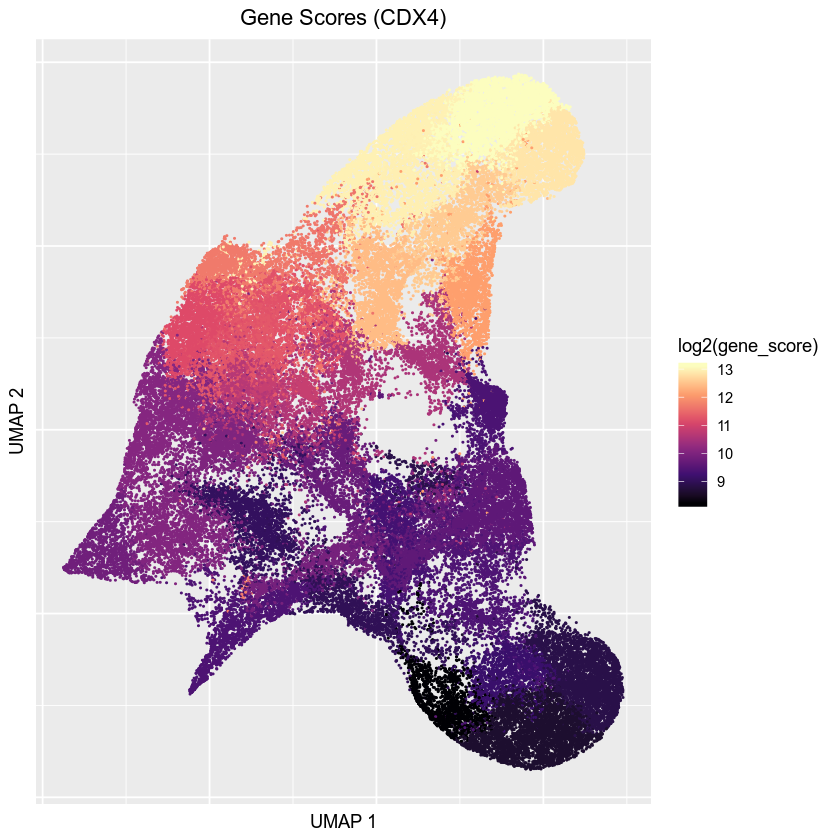

In [280]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, gene_score=as.numeric(distal_summed_gene[GENE, ])[clusters])
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=log2(gene_score))) +
ggtitle(sprintf("Gene Scores (%s)", GENE)) + 
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(oob=squish, option = "A") +
theme(plot.title = element_text(hjust = 0.5),
     axis.ticks = element_blank(),
     axis.text =element_blank())

In [ ]:
# cts_to_cluster = log_norm_cts 
cts_to_cluster = t(scale(t(distal_summed_gene)))

In [ ]:
# ADD RAND SEED - not required

km_mb = MiniBatchKmeans(cts_to_cluster, 
                        batch_size = 1000,
                        clusters=10,
                        num_init = 10, 
                        verbose = FALSE)

In [ ]:
# reorder based on hierarchical clustering
# pr_mb = predict_MBatchKMeans(cts_to_cluster, km_mb$centroids)

# distance    = dist(t(scale(t(km_mb$centroids))))
# cluster     = hclust(distance, method="ward")
# dendrogram  = as.dendrogram(cluster)
# rowInd = rev(order.dendrogram(dendrogram))
# pr_mb = order(rowInd)[pr_mb]

In [ ]:
# no hierarchical clustering, follow order of km_mb$centroids
pr_mb = predict_MBatchKMeans(cts_to_cluster, km_mb$centroids)

In [ ]:
table(pr_mb)

In [ ]:
order(rowVars(km_mb$centroids))

In [ ]:
cts_clustered = cts_to_cluster[order(pr_mb),]
head(cts_clustered, 2)

In [ ]:
options(repr.plot.width = 5, repr.plot.height = 5)
hist(as.vector(cts_clustered))

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 10)

idxs = seq(1, nrow(cts_clustered), 10) # if subsample
ggplot(data = melt(cts_clustered[idxs, ]), 
       mapping = aes(x = Var2,
                     y = Var1,
                     fill = value)) +
geom_tile()  + ylab(NULL) + xlab("Condition") +  
geom_raster(aes(fill=value)) +
scale_fill_viridis(limits=c(-2.5, 2.5), oob=squish, option = "A") +
# scale_fill_viridis(option="A") + 
# scale_fill_gradient2(low="red", mid="black", high="blue") +
facet_grid(sort(pr_mb)[idxs] ~ ., switch = "y", scales = "free_y", space = "free_y")+
# theme_classic() +
theme(axis.text.x=element_text(angle=90,hjust=1),
      axis.text.y=element_blank(),
      axis.ticks.y=element_blank())
#       panel.spacing.y = unit(0.03, "cm"),
#       strip.text.y = element_text(size = 3))  
#       strip.background = element_rect(size = 0.1))

# ggsave(sprintf("figs/%s_heatmap_idr_n%d.jpeg", format(Sys.Date(), format='%Y%m%d'), length(table(pr_mb))),
#        dpi=1000)

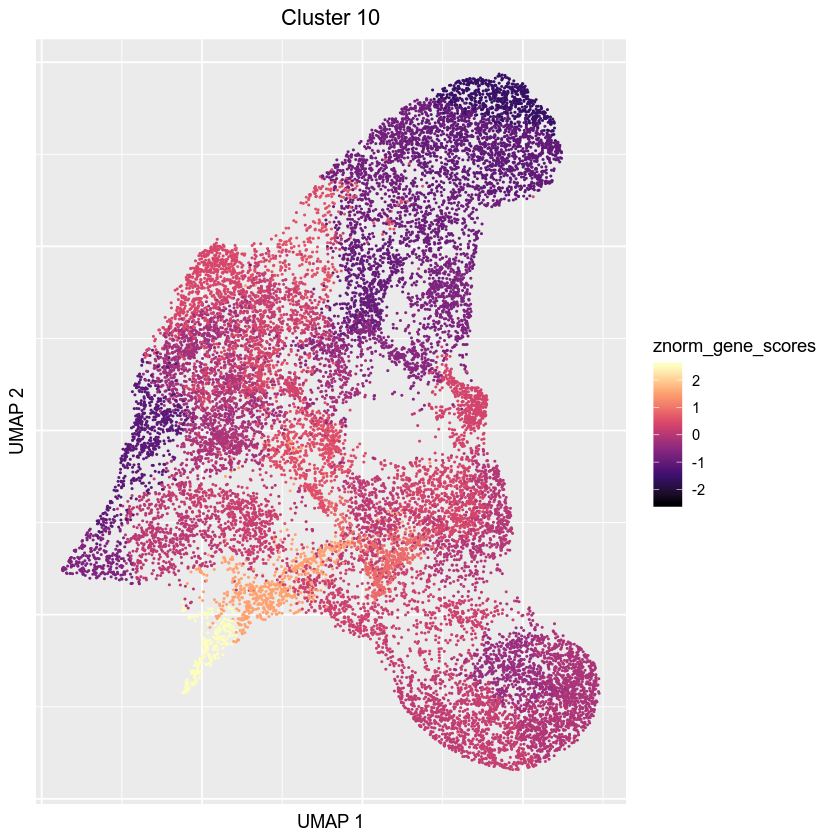

In [68]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(x.sp@umap, znorm_gene_scores=cts_clustered["KRT32",][clusters])
# shuffle so days don't overlap
df = df[sample(dim(df)[1], 20000), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=znorm_gene_scores)) +
ggtitle(sprintf("Cluster %d", i)) + 
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(limits=c(-2.5, 2.5), oob=squish, option = "A") +
theme(plot.title = element_text(hjust = 0.5),
      axis.ticks = element_blank(),
     axis.text =element_blank())

In [58]:
plots = list()
for (i in seq(1,10)) {
    df = data.frame(x.sp@umap, znorm_gene_scores=km_mb$centroids[i, ][clusters])
    # shuffle so days don't overlap
    df = df[sample(dim(df)[1], 20000), ]
    
    plots[[i]] <- ggplot(df) +
    # ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
    geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=znorm_gene_scores)) +
    ggtitle(sprintf("Cluster %d", i)) + 
    xlab("UMAP 1") + ylab("UMAP 2") +
    scale_color_viridis_c(limits=c(-2.5, 2.5), oob=squish, option = "A") +
    theme(plot.title = element_text(hjust = 0.5),
         legend.position = "none",
         axis.ticks = element_blank(),
         axis.text =element_blank())
}

In [60]:
df = data.frame(x.sp@umap, znorm_gene_scores=km_mb$centroids[1, ][clusters])
# shuffle so days don't overlap
df = df[sample(dim(df)[1], 20000), ]

cur_plot <- ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap.1 , y=umap.2, col=znorm_gene_scores)) +
ggtitle(sprintf("Cluster %d", i)) + 
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(limits=c(-2.5, 2.5), oob=squish, option = "A") +
theme(plot.title = element_text(hjust = 0.5),
     axis.ticks = element_blank(),
     axis.text =element_blank())

legend_only = cowplot::get_legend(cur_plot)

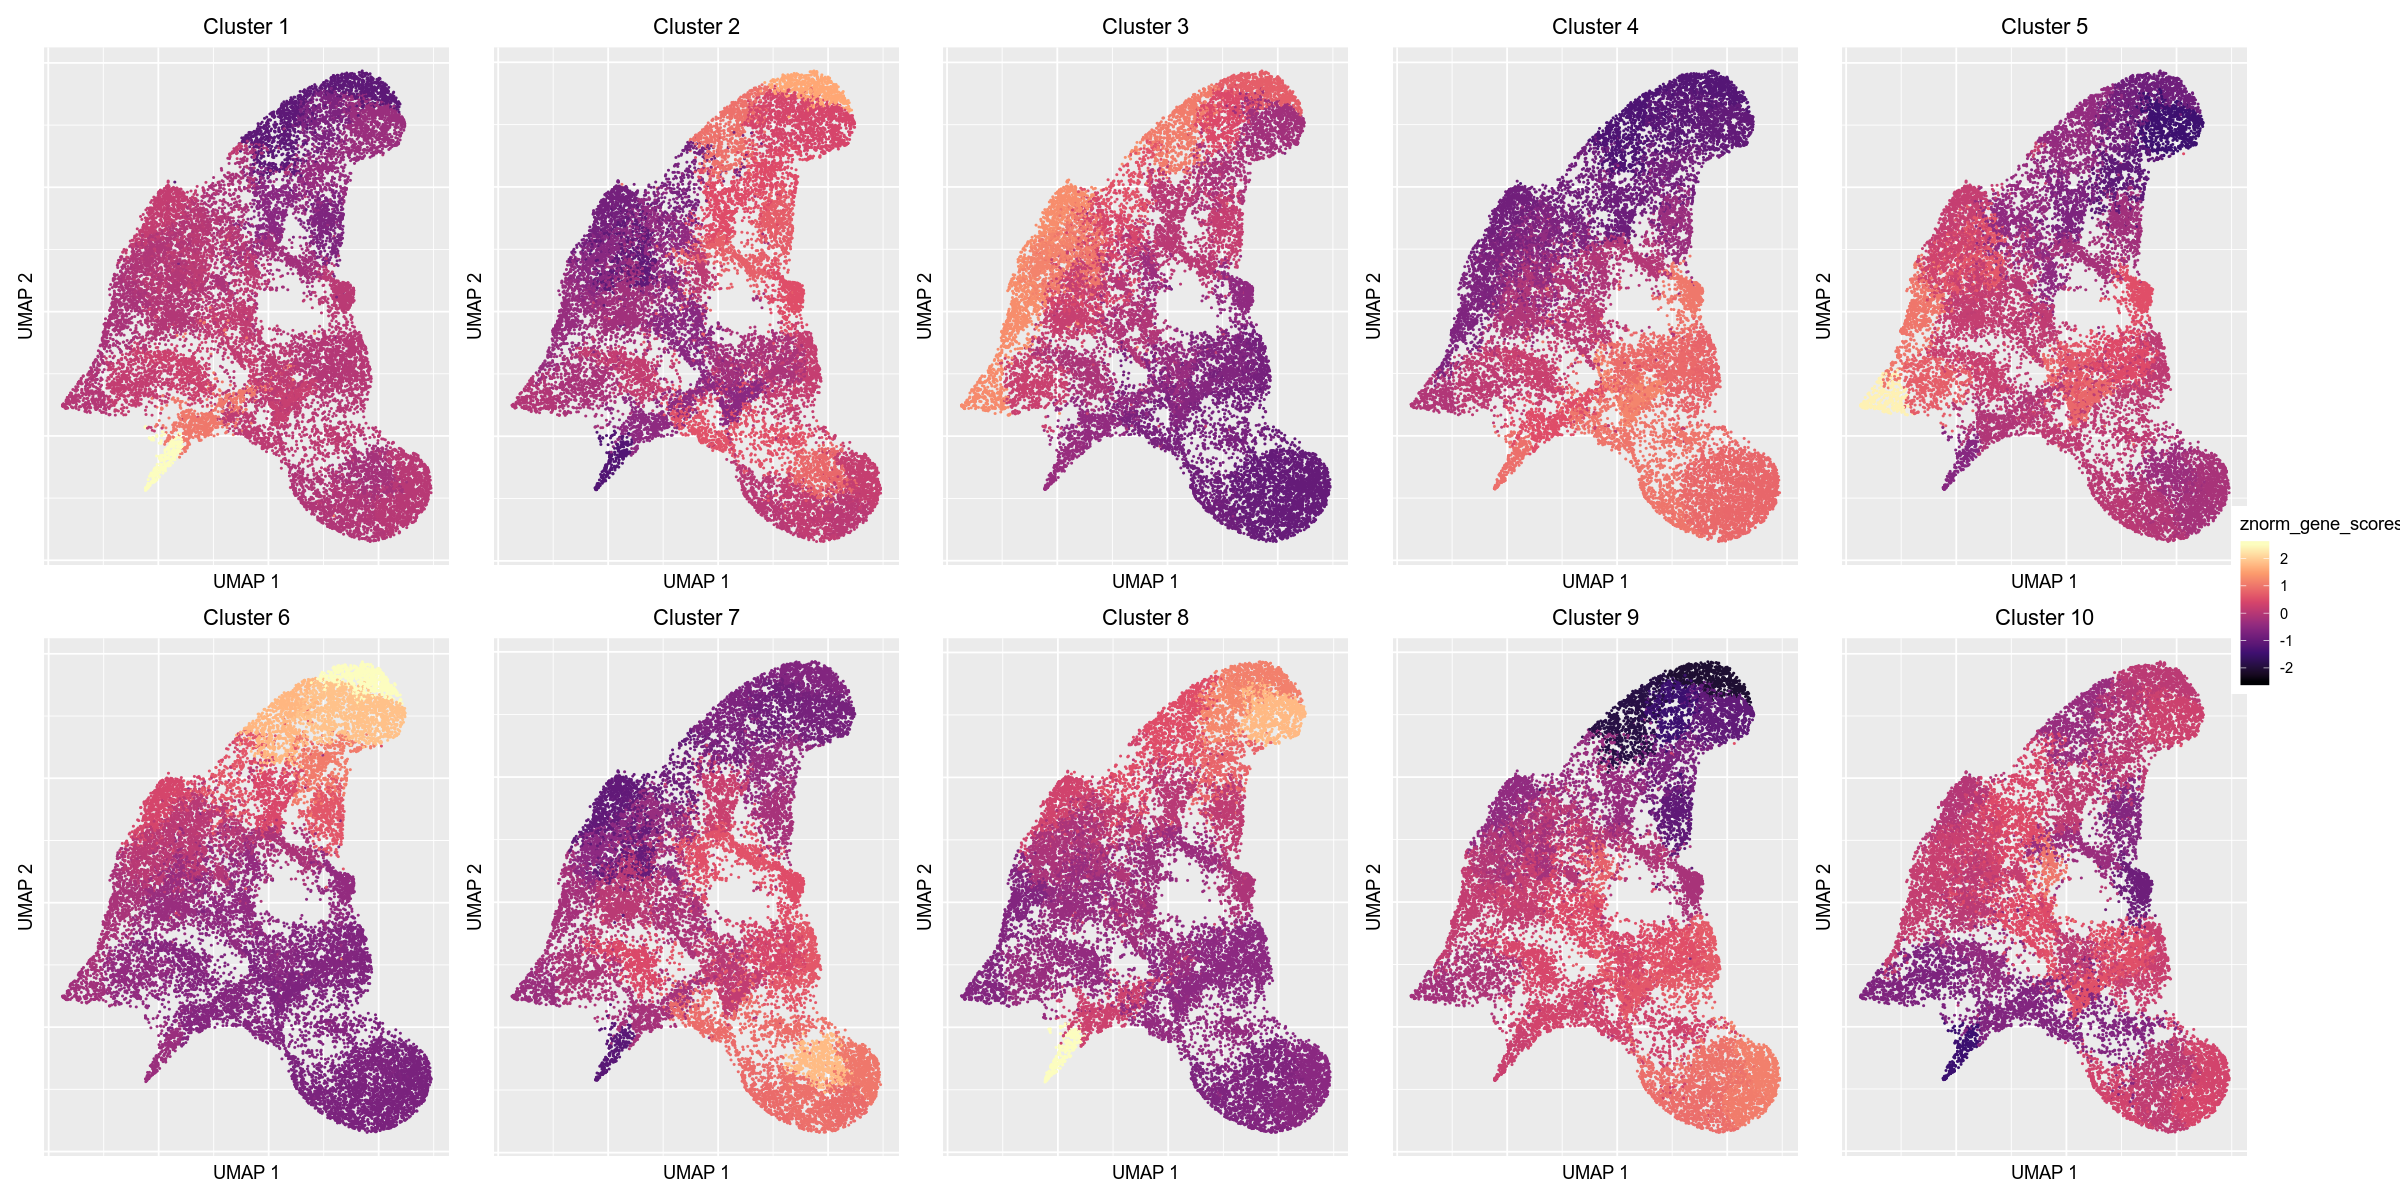

In [59]:
options(repr.plot.width = 20, repr.plot.height = 10)
wrap_plots(wrap_plots(plots, ncol = 5), legend_only, widths=c(0.95,0.05)) 
# ggsave(sprintf("figs/%s_gridmap_gene_score_n%d.jpeg", format(Sys.Date(), format='%Y%m%d'), length(table(pr_mb))),
#        dpi=300, width = 20, height = 10)

## Write Gene Lists for Clusters

In [62]:
CLUSTER_IDX = 1
NORM = 'znorm_gene_scores'
LIST_PATH = sprintf("gene_lists/%s_%s_n%d/idx%d.txt", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)), CLUSTER_IDX)
# rownames(vsd_assay_to_cluster_normalized)[(which(pr_mb==CLUSTER_IDX))]
LIST_PATH

[1] "gene_lists/20200309_znorm_gene_scores_n10/idx1.txt"

In [64]:
for (i in seq(1,length(table(pr_mb)))){
LIST_PATH = sprintf("gene_lists/%s_%s_n%d/idx%d.txt", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)), i)
fileConn = file(LIST_PATH)
writeLines(rownames(cts_to_cluster)[(which(pr_mb==i))], fileConn)
close(fileConn)}

In [65]:
ALL_PEAKS_BED_PATH = sprintf("gene_lists/%s_%s_n%d/all_genes.txt", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)))
print(ALL_PEAKS_BED_PATH)
fileConn = file(ALL_PEAKS_BED_PATH)
writeLines(rownames(cts_to_cluster), fileConn)
close(fileConn)

[1] "gene_lists/20200309_znorm_gene_scores_n10/all_genes.txt"
